# Project: Evaluate STRIPS Pricing Scheme 3
In this example, students will evaluate pricing scheme 3 for the [Registered Interest and Principal of Securities (STRIPS)](https://www.treasurydirect.gov/marketable-securities/strips/) bonds.

## Learning objectives
* __Prerequisite__: Load the Treasury auction dataset, which contains data from recent auctions or treasury bills, notes, and bonds
* __Objective 1__: Build a model for a treasury bond and strip the bond's coupon payments and face value.
* __Objective 2__: Evaluate STRIPS pricing approach from Scheme 3.
    * `Check`: Visualize the first $m$ STRIPS products
    * `Check`: Visualize the yield curve
    * `Check`: How much do we collect from the sale of the STRIPS

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

## Prerequisite: Load the Treasury auction dataset
We'll explore `T-note` and `T-bond` prices from United States Treasury auctions between October 2022 and August 2023 downloaded as a `CSV` file using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). 
* We load the `CSV` dataset using the `MyTreasuryNotesAndBondsDataSet()` function, which returns the auction data as a `DataFrame`. We store the auction data in the `dataset`

In [5]:
dataset = MyTreasuryNotesAndBondsDataSet();

## Objective 1: Select a random note or bond and generate STRIPS
We'll select a random note or bond, compute its price, compare it to the auction price (to `check` our price codes), and then `strip` the selected note or bond.
* First, determine how many notes and bonds we have in the `dataset` using the [nrow function](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.nrow) that is exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl). Then, compute a random index using the [built-in Julia rand function](https://docs.julialang.org/en/v1/stdlib/Random/). Store the auction data for the random note or bond in the `random_note_or_bond` variable

In [7]:
number_of_notes_and_bonds = nrow(dataset)
selected_bond_index = rand(1:number_of_notes_and_bonds);
random_note_or_bond = dataset[selected_bond_index,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,High Yield,Interest Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64,Float64
23,91282CHB0,Note,3-Year,05/09/2023,05/15/2023,05/15/2026,99.8029,0.03695,0.03625


Next, instantiate a discrete compounding model, and store this model in the `discrete_compounding` variable:

In [9]:
# Build a discrete compounding model -
discrete_compounding = DiscreteCompoundingModel();

Get the parameters from `random_note_or_bond` variable to test our price calculation. 
* In particular, we set the face (par) value `Vₚ,` the duration `T` (which we convert to the number of years using the `securityterm` function), the yield field, i.e., the $\bar{r}$ value in the discount rate, the coupon rate $c$ and the number of coupon payments per year `λ`.

In [11]:
Vₚ = 100.0; # face value of the note or bond
T = random_note_or_bond[Symbol("Security Term")] |> String |> securityterm; # term as a Float64
r̄ = random_note_or_bond[Symbol("High Yield")]; # Effective discount rate
c = random_note_or_bond[Symbol("Interest Rate")]; # Interest rate (coupon rate)
λ = 2; # number of coupon payments per year

Finally,  compute the price of the note (or bond) using the short-cut syntax and the discount model. We store the populated note or bond in the `model` variable, and the computed price in the `nominal_computed_price` (the `price` field on the `model`):

In [13]:
### BEGIN SOLUTION
model = build(MyUSTreasuryCouponSecurityModel, (
            par = Vₚ, T = T, rate = r̄, coupon = c, λ = λ
        )) |> discrete_compounding;

nominal_computed_price = model.price;
### END SOLUTION

### TODO: Strip the note or bond to create a collection of zero-coupon payments
Generate the `strips` dictionary of zero-coupon `MyUSTreasuryCouponSecurityModel` models using [the `strip(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.strip) exported by the [VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) 
* The resulting `strips` dictionary stores the generated bonds in order of duration, with their indexes serving as keys and the [corresponding `MyUSTreasuryZeroCouponBondModel` instances](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) as values. 

In [15]:
### END SOLUTION
strips = VLQuantitativeFinancePackage.strip(model);
### END SOLUTION

## Objective 2: Evaluate STRIPS pricing approach from Scheme 3
Let's develop a new pricing approach for STRIPS. Suppose the interest (discount) rate that we are willing to sell the bond is given by:
$$
\bar{r}_{i} = \theta_{1}+\theta_{2}\cdot\left(i-1\right)^{\beta}
$$
where $i$ denotes the STRIPS index, $\theta_{1}$ denotes the interest rate for the shortest term bond, $\theta_{2}$ governs how fast the rate escalates for each pass of the loop, i.e., for each bond of longer maturity that we sell, and $\beta$ is a sensitivity parameter.
* Because $\theta_{1}>{0}$, $\theta_{2}\geq{0}$, and $\beta>0$ this scheme will give a _normal_ yield curve $\bar{r}_{i}\leq\bar{r}_{i+1}$, i.e., longer-term maturity will have a higher-yield compared to shorter-term bonds.

In [17]:
θ₁, θ₂, β = 0.015, 0.001, 0.5;
number_of_zc_bonds = length(strips)
for i ∈ 1:number_of_zc_bonds

    ### BEGIN SOLUTION
    zc_model = strips[i];
    zc_model.rate = θ₁ + θ₂*(i-1)^β
    zc_model = price(zc_model, discrete_compounding)
    ### END SOLUTION
end

#### Check: Visualize the first $m$ STRIPS products
`Unhide` the next code cell to see how we build a table displaying the bond price information. 
* First, specify the `number_of_strips_to_view.` Then, we'll loop through each STRIP and access the respective models from the `strips` dictionary using the bracket notation `strips[i],` where `i` represents the STRIP index. 
* Next, we'll add pricing, maturity, etc. data to the `strips_table_data_array` and display the resulting table by calling the `pretty_table(…)` function, which is exported by the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [19]:
number_of_strips = length(strips);
number_of_strips_to_view = number_of_strips ≥ 10 ? 10 : number_of_strips
strips_table_data_array = Array{Any,2}(undef, number_of_strips, 6);
strips_table_header_array = (["", "Maturity","Face","Price","r̄", "Discount"],
    ["","YR","USD","USD","", "price/face"]);
for i ∈ 1:number_of_strips

    zc_model = strips[i];
    strips_table_data_array[i,1] = i
    strips_table_data_array[i,2] = zc_model.T
    strips_table_data_array[i,3] = zc_model.par
    strips_table_data_array[i,4] = zc_model.price
    strips_table_data_array[i,5] = zc_model.rate  
    strips_table_data_array[i,6] = (zc_model.price/zc_model.par)
end
pretty_table(strips_table_data_array[1:number_of_strips_to_view,1:end], 
    header=strips_table_header_array, tf = tf_simple)

==== ========== ======== ========= =========== =============
      Maturity     Face     Price           r̄     Discount 
            YR      USD       USD               price/face 
==== ========== ======== ========= =========== =============
  1        0.5   1.8125   1.79901       0.015     0.992556
  2        1.0   1.8125   1.78384       0.016      0.98419
  3        1.5   1.8125    1.7686   0.0164142     0.975777
  4        2.0   1.8125   1.75309   0.0167321     0.967224
  5        2.5   1.8125   1.73739       0.017     0.958563
  6        3.0   1.8125   1.72154   0.0172361     0.949816
  7        3.0    100.0   94.9214   0.0174495     0.949214
==== ========== ======== ========= =========== =============


#### Check: Visualize the yield curve
`Unhide` the next code cell to see how we plotted the yield curve suggested by your choice of the $\theta_{1},\theta_{2}$ and $\beta$ parameters.

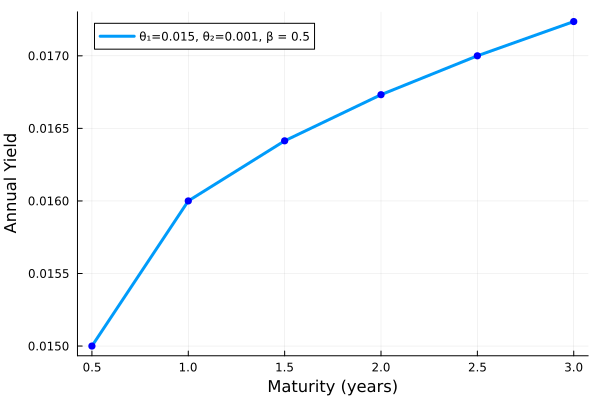

In [21]:
plot(strips_table_data_array[1:end-1,2], strips_table_data_array[1:end-1,5],lw=3,
    label="θ₁=$(θ₁), θ₂=$(θ₂), β = $(β)")
scatter!(strips_table_data_array[1:end-1,2], strips_table_data_array[1:end-1,5], 
label="", msc="blue", mc="blue")
xlabel!("Maturity (years)",fontsize=18)
ylabel!("Annual Yield", fontsize=18)

#### Check: How much do we collect from the sale of the STRIPS?
In this scenario, we purchased an original instrument from the [United States Treasury](https://www.treasurydirect.gov/) for $V_{B}$, stripped the coupons and face, and resold them. How much did we make from the sale of the STRIPS?

In [23]:
resale_total = sum(strips_table_data_array[:,4]);
println("Purchased bond $(selected_bond_index) for $(round(nominal_computed_price,digits=3)) USD, stripped and resold it for $(round(resale_total, digits=3)) USD")

Purchased bond 23 for 99.803 USD, stripped and resold it for 105.485 USD


#### Discussion
Can you adjust the values for $\theta_{1},\theta_{2}$ and $\beta$ parameters so that we pay for the cost of the original note or bond? 

### Summary
* The yield curve produced by this pricing scheme (when $\theta_{2}>0$) will always be normal, i.e., longer-term securities will have a higher yield compared with shorter-term instruments.
* However, depending upon the values for $\theta_{1},\theta_{2}$ and $\beta$, the total revenue obtained from resale of the STRIPS products may be _less than_ the cost of the original note or bond.
* Different values for the $\theta_{1},\theta_{2}$ and $\beta$ parameters generate different prices for the STRIPS products. However, there is no guarantee these will be competitive in the secondary market.

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.